### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification
import sys, os
sys.path.append(os.path.abspath(".."))  
from dataset import PACSDataset
from vit_grqo import ViTGRQO, grqo_loss_from_gradients
from encoder_decoder_vit import VisualDecoder, MultiheadAttn, DecoderAttn
from Visual_query_heads import QueryLosses, GRQO

### CONFIG 

In [2]:
import os
from datasets import load_dataset
from PIL import Image

# Your constants
DATA_ROOT = r"D:\Haseeb\SPROJ\PACS ViT\pacs_data\pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
BATCH_SIZE = 32
NUM_CLASSES = 7
NUM_EPOCHS = 5
LR = 1e-4
TOPK = 24
ALPHA = 2.0
BETA = 0.5
TAU = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dataset = load_dataset("flwrlabs/pacs", split="train")

# os.makedirs(DATA_ROOT, exist_ok=True)
# for domain in DOMAINS:
#     for cls in CLASSES:
#         os.makedirs(f"{DATA_ROOT}/{domain}/{cls}", exist_ok=True)

# for i, example in enumerate(dataset):
#     domain = example["domain"]  
#     label_idx = example["label"]  
#     label = CLASSES[label_idx]

#     if domain not in DOMAINS:
#         raise ValueError(f"Unexpected domain: {domain}. Expected one of {DOMAINS}")
#     if label not in CLASSES:
#         raise ValueError(f"Unexpected label: {label}. Expected one of {CLASSES}")
    
#     image = example["image"]
#     image.save(f"{DATA_ROOT}/{domain}/{label}/image_{i}.jpg")


### Data

In [3]:
TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
pacs_data = PACSDataset(DATA_ROOT, DOMAINS, TRANSFORM, BATCH_SIZE)
ALL_DOMAINS = ['photo', 'art_painting', 'cartoon', 'sketch']
LEAVE_OUT = 'sketch'  
TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
VAL_DOMAIN = LEAVE_OUT

train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation loader
val_loader = pacs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

### Model 

In [4]:
from transformers import ViTModel, AutoFeatureExtractor
import torch
import torch.nn as nn

# ViT-Tiny Backbone from Hugging Face ---
vit_encoder = ViTModel.from_pretrained("WinKawaks/vit-tiny-patch16-224")
HIDDEN_DIM = vit_encoder.config.hidden_size  # 192 for ViT-Tiny

# GRQO Hyperparameters ---
NUM_HEADS = 6
DROPOUT = 0.1
NUM_LAYERS = 3
DDROPOUT = 0.1
NUM_TOKENS = 32
TEMPERATURE = 0.1
ALPHA = 2.0
BETA = 0.5
TAU = 1e-3
LAMBDA_GRQO = 1.0
TEACHER_EMA = 0.99
NUM_CLASSES = 7

# GRQO Decoder ---
grqo_model = GRQO(
    Hidden_dim=HIDDEN_DIM,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    num_tokens=NUM_TOKENS,
    ddropout=DDROPOUT,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    temperature=TEMPERATURE,
    alpha=ALPHA,
    beta=BETA,
    tau=TAU,
    lambda_grqo=LAMBDA_GRQO,
    teacher_ema=TEACHER_EMA,
    reward_proxy="taylor"
)

# Full ViTGRQO Model ---
class ViTGRQO(nn.Module):
    def __init__(self, vit_encoder, grqo_model):
        super().__init__()
        self.vit = vit_encoder
        self.grqo = grqo_model

    def forward(self, x, labels=None):
        # Get patch embeddings from HF ViT (exclude CLS token)
        outputs = self.vit(pixel_values=x, output_hidden_states=True)
        patch_tokens = outputs.last_hidden_state[:, 1:, :]  # [B, N, D] skip CLS token
        return self.grqo(patch_tokens, labels)

# Initialize model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Model initialized on {device}")
print(f"Hidden dim: {HIDDEN_DIM}, Num tokens: {NUM_TOKENS}")

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized on cuda
Hidden dim: 192, Num tokens: 32


### training

In [5]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_grqo_loss = 0.0
    correct = 0
    total_samples = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images, labels)
        
        # Extract losses
        loss = output['loss']
        cls_loss = output['cls_loss']
        grqo_loss = output['grqo_loss']
        preds = output['preds']
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item() * images.size(0)
        total_cls_loss += cls_loss.item() * images.size(0)
        total_grqo_loss += grqo_loss.item() * images.size(0)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, '
                  f'Cls: {cls_loss.item():.4f}, GRQO: {grqo_loss.item():.4f}')
    
    avg_loss = total_loss / total_samples
    avg_cls_loss = total_cls_loss / total_samples
    avg_grqo_loss = total_grqo_loss / total_samples
    accuracy = correct / total_samples
    
    return avg_loss, avg_cls_loss, avg_grqo_loss, accuracy

### evaluation

In [6]:
def validate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        # GRQO needs gradients even during validation
        with torch.set_grad_enabled(True):
            output = model(images, labels)
            preds = output['preds']
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

### finetuning 

In [7]:
ALL_DOMAINS = ['sketch', 'photo', 'art_painting', 'cartoon']
lodo_results = {}

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out domain '{LEAVE_OUT}' ===")
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # Create data loaders
    train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    val_loader = pacs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

    # Reset model for this split
    model = ViTGRQO(vit_encoder, grqo_model).to(DEVICE)
    FREEZE_VIT = False
    if FREEZE_VIT:
        for param in model.vit.parameters():
            param.requires_grad = False
    
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=LR, weight_decay=0.01
    )
    #  Optimizer ---
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.AdamW(trainable_params, lr=LR, weight_decay=0.01)
    best_val_acc = 0.0
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train
        train_loss, train_cls, train_grqo, train_acc = train_epoch(model, train_loader, optimizer, DEVICE)
        
        # Validate  
        val_acc = validate(model, val_loader, DEVICE)
        
        print(f"Train - Loss: {train_loss:.4f}, Cls: {train_cls:.4f}, "
              f"GRQO: {train_grqo:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Acc ({VAL_DOMAIN}): {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    lodo_results[VAL_DOMAIN] = best_val_acc
    print(f"Best Val Acc for {VAL_DOMAIN}: {best_val_acc:.4f}")

# Cell 8: Results Summary
print("\n" + "="*50)
print("LODO RESULTS SUMMARY")
print("="*50)
for domain, acc in lodo_results.items():
    print(f"{domain:15}: {acc:.4f}")

avg_lodo = sum(lodo_results.values()) / len(lodo_results)
print(f"{'Average':15}: {avg_lodo:.4f}")
print("="*50)


=== LODO: Leaving out domain 'sketch' ===

Epoch 1/5
Batch 0, Loss: 1.9548, Cls: 1.8953, GRQO: 0.0595
Batch 50, Loss: 0.7612, Cls: 0.7520, GRQO: 0.0092
Batch 100, Loss: 0.3127, Cls: 0.3074, GRQO: 0.0052
Batch 150, Loss: 0.3211, Cls: 0.3170, GRQO: 0.0041
Train - Loss: 0.6271, Cls: 0.6171, GRQO: 0.0101, Acc: 0.8045
Val Acc (sketch): 0.5305

Epoch 2/5
Batch 0, Loss: 0.1135, Cls: 0.1094, GRQO: 0.0040
Batch 50, Loss: 0.1958, Cls: 0.1927, GRQO: 0.0031
Batch 100, Loss: 0.0703, Cls: 0.0672, GRQO: 0.0030
Batch 150, Loss: 0.0314, Cls: 0.0285, GRQO: 0.0028
Train - Loss: 0.1170, Cls: 0.1137, GRQO: 0.0034, Acc: 0.9662
Val Acc (sketch): 0.4644

Epoch 3/5
Batch 0, Loss: 0.0164, Cls: 0.0136, GRQO: 0.0028
Batch 50, Loss: 0.0764, Cls: 0.0738, GRQO: 0.0026
Batch 100, Loss: 0.0074, Cls: 0.0050, GRQO: 0.0024
Batch 150, Loss: 0.1692, Cls: 0.1668, GRQO: 0.0023
Train - Loss: 0.0491, Cls: 0.0465, GRQO: 0.0026, Acc: 0.9864
Val Acc (sketch): 0.4326

Epoch 4/5
Batch 0, Loss: 0.0062, Cls: 0.0040, GRQO: 0.0022
Bat

In [8]:
ALL_DOMAINS = ['sketch', 'photo', 'art_painting', 'cartoon']
lodo_results = {}

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out domain '{LEAVE_OUT}' ===")
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # Create data loaders
    train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    val_loader = pacs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

    vit_encoder = ViTModel.from_pretrained("WinKawaks/vit-tiny-patch16-224")
    grqo_model = GRQO(
        Hidden_dim=HIDDEN_DIM,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        num_tokens=NUM_TOKENS,
        ddropout=DDROPOUT,
        num_layers=NUM_LAYERS,
        num_classes=NUM_CLASSES,
        temperature=TEMPERATURE,
        alpha=ALPHA,
        beta=BETA,
        tau=TAU,
        lambda_grqo=LAMBDA_GRQO,
        teacher_ema=TEACHER_EMA,
        reward_proxy="taylor"
    )
    model = ViTGRQO(vit_encoder, grqo_model).to(DEVICE)

    # Optionally freeze ViT
    FREEZE_VIT = True
    if FREEZE_VIT:
        for param in model.vit.parameters():
            param.requires_grad = False
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=LR, weight_decay=0.01
    )

    best_val_acc = 0.0
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train
        train_loss, train_cls, train_grqo, train_acc = train_epoch(model, train_loader, optimizer, DEVICE)
        
        # Validate  
        val_acc = validate(model, val_loader, DEVICE)
        
        print(f"Train - Loss: {train_loss:.4f}, Cls: {train_cls:.4f}, "
              f"GRQO: {train_grqo:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Acc ({VAL_DOMAIN}): {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    lodo_results[VAL_DOMAIN] = best_val_acc
    print(f"Best Val Acc for {VAL_DOMAIN}: {best_val_acc:.4f}")

# ---------------- Results Summary ----------------
print("\n" + "="*50)
print("LODO RESULTS SUMMARY")
print("="*50)
for domain, acc in lodo_results.items():
    print(f"{domain:15}: {acc:.4f}")

avg_lodo = sum(lodo_results.values()) / len(lodo_results)
print(f"{'Average':15}: {avg_lodo:.4f}")
print("="*50)



=== LODO: Leaving out domain 'sketch' ===


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
Batch 0, Loss: 2.0116, Cls: 1.9384, GRQO: 0.0733
Batch 50, Loss: 1.2331, Cls: 1.2216, GRQO: 0.0115
Batch 100, Loss: 0.6403, Cls: 0.6328, GRQO: 0.0075
Batch 150, Loss: 0.3218, Cls: 0.3151, GRQO: 0.0067
Train - Loss: 0.9466, Cls: 0.9344, GRQO: 0.0123, Acc: 0.7226
Val Acc (sketch): 0.4071

Epoch 2/5
Batch 0, Loss: 0.2775, Cls: 0.2709, GRQO: 0.0066
Batch 50, Loss: 0.3211, Cls: 0.3157, GRQO: 0.0054
Batch 100, Loss: 0.1487, Cls: 0.1432, GRQO: 0.0055
Batch 150, Loss: 0.1975, Cls: 0.1929, GRQO: 0.0046
Train - Loss: 0.2812, Cls: 0.2757, GRQO: 0.0055, Acc: 0.9163
Val Acc (sketch): 0.4237

Epoch 3/5
Batch 0, Loss: 0.0898, Cls: 0.0848, GRQO: 0.0050
Batch 50, Loss: 0.1194, Cls: 0.1150, GRQO: 0.0044
Batch 100, Loss: 0.3322, Cls: 0.3281, GRQO: 0.0041
Batch 150, Loss: 0.1268, Cls: 0.1225, GRQO: 0.0043
Train - Loss: 0.1740, Cls: 0.1696, GRQO: 0.0044, Acc: 0.9509
Val Acc (sketch): 0.4466

Epoch 4/5
Batch 0, Loss: 0.0236, Cls: 0.0200, GRQO: 0.0036
Batch 50, Loss: 0.1824, Cls: 0.1786, GRQO: 0.0

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
Batch 0, Loss: 1.9964, Cls: 1.9269, GRQO: 0.0695
Batch 50, Loss: 1.4568, Cls: 1.4489, GRQO: 0.0078
Batch 100, Loss: 1.0242, Cls: 1.0157, GRQO: 0.0085
Batch 150, Loss: 0.7257, Cls: 0.7192, GRQO: 0.0065
Batch 200, Loss: 1.0602, Cls: 1.0545, GRQO: 0.0056
Train - Loss: 1.0948, Cls: 1.0847, GRQO: 0.0102, Acc: 0.6091
Val Acc (photo): 0.8862

Epoch 2/5
Batch 0, Loss: 0.3729, Cls: 0.3680, GRQO: 0.0049
Batch 50, Loss: 0.5391, Cls: 0.5333, GRQO: 0.0058
Batch 100, Loss: 0.4877, Cls: 0.4830, GRQO: 0.0047
Batch 150, Loss: 0.2822, Cls: 0.2773, GRQO: 0.0049
Batch 200, Loss: 0.4944, Cls: 0.4899, GRQO: 0.0045
Train - Loss: 0.4984, Cls: 0.4936, GRQO: 0.0047, Acc: 0.8320
Val Acc (photo): 0.9311

Epoch 3/5
Batch 0, Loss: 0.3547, Cls: 0.3500, GRQO: 0.0047
Batch 50, Loss: 0.4037, Cls: 0.3994, GRQO: 0.0043
Batch 100, Loss: 0.1546, Cls: 0.1506, GRQO: 0.0040
Batch 150, Loss: 0.1935, Cls: 0.1897, GRQO: 0.0038
Batch 200, Loss: 0.3427, Cls: 0.3389, GRQO: 0.0038
Train - Loss: 0.3507, Cls: 0.3467, GRQO: 

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
Batch 0, Loss: 1.9857, Cls: 1.9284, GRQO: 0.0573
Batch 50, Loss: 1.3456, Cls: 1.3355, GRQO: 0.0101
Batch 100, Loss: 0.8955, Cls: 0.8884, GRQO: 0.0071
Batch 150, Loss: 0.8067, Cls: 0.7995, GRQO: 0.0072
Train - Loss: 1.0206, Cls: 1.0107, GRQO: 0.0099, Acc: 0.6479
Val Acc (art_painting): 0.6780

Epoch 2/5
Batch 0, Loss: 0.7534, Cls: 0.7475, GRQO: 0.0059
Batch 50, Loss: 0.3815, Cls: 0.3758, GRQO: 0.0057
Batch 100, Loss: 0.4639, Cls: 0.4584, GRQO: 0.0055
Batch 150, Loss: 0.2839, Cls: 0.2792, GRQO: 0.0047
Train - Loss: 0.4487, Cls: 0.4436, GRQO: 0.0051, Acc: 0.8459
Val Acc (art_painting): 0.7634

Epoch 3/5
Batch 0, Loss: 0.3890, Cls: 0.3845, GRQO: 0.0045
Batch 50, Loss: 0.2859, Cls: 0.2819, GRQO: 0.0040
Batch 100, Loss: 0.2551, Cls: 0.2511, GRQO: 0.0040
Batch 150, Loss: 0.4370, Cls: 0.4333, GRQO: 0.0037
Train - Loss: 0.3224, Cls: 0.3184, GRQO: 0.0040, Acc: 0.8908
Val Acc (art_painting): 0.7976

Epoch 4/5
Batch 0, Loss: 0.1610, Cls: 0.1574, GRQO: 0.0036
Batch 50, Loss: 0.2536, Cls:

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
Batch 0, Loss: 2.0078, Cls: 1.9337, GRQO: 0.0741
Batch 50, Loss: 1.3149, Cls: 1.3067, GRQO: 0.0083
Batch 100, Loss: 0.7033, Cls: 0.6937, GRQO: 0.0096
Batch 150, Loss: 0.5375, Cls: 0.5301, GRQO: 0.0075
Train - Loss: 1.0121, Cls: 1.0011, GRQO: 0.0111, Acc: 0.6662
Val Acc (cartoon): 0.5736

Epoch 2/5
Batch 0, Loss: 0.5601, Cls: 0.5547, GRQO: 0.0054
Batch 50, Loss: 0.5239, Cls: 0.5190, GRQO: 0.0049
Batch 100, Loss: 0.2919, Cls: 0.2869, GRQO: 0.0050
Batch 150, Loss: 0.3287, Cls: 0.3243, GRQO: 0.0045
Train - Loss: 0.4300, Cls: 0.4251, GRQO: 0.0049, Acc: 0.8503
Val Acc (cartoon): 0.5821

Epoch 3/5
Batch 0, Loss: 0.2924, Cls: 0.2883, GRQO: 0.0041
Batch 50, Loss: 0.2417, Cls: 0.2376, GRQO: 0.0041
Batch 100, Loss: 0.2929, Cls: 0.2888, GRQO: 0.0041
Batch 150, Loss: 0.3342, Cls: 0.3303, GRQO: 0.0038
Train - Loss: 0.3042, Cls: 0.3002, GRQO: 0.0040, Acc: 0.8929
Val Acc (cartoon): 0.5991

Epoch 4/5
Batch 0, Loss: 0.1892, Cls: 0.1857, GRQO: 0.0035
Batch 50, Loss: 0.2126, Cls: 0.2087, GRQO: 

In [9]:
print("\n=== Leave-One-Domain-Out (LODO) Training & Validation ===")

lodo_results = {}  # store per-domain results

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out {LEAVE_OUT.upper()} for validation ===")
    
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # Train loader (concat all train domains)
    train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # Validation loader (only leave-out domain)
    val_loader = pacs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

    # Model (reset for each LODO run)
    model = ViTForImageClassification.from_pretrained(
        "WinKawaks/vit-tiny-patch16-224",
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (Leave out {VAL_DOMAIN})")

        # ---- Train ----
        model.train()
        running_loss, running_corrects, running_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            logits = outputs.logits
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            running_loss += loss.item() * images.size(0)
            running_corrects += (preds == labels).sum().item()
            running_samples += labels.size(0)

        train_loss = running_loss / running_samples
        train_acc = running_corrects / running_samples

        # ---- Validation on held-out domain ----
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                preds = outputs.logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total if total > 0 else 0.0

        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Acc ({VAL_DOMAIN}): {val_acc:.4f}")

        # Track best
        best_val_acc = max(best_val_acc, val_acc)

    # Save best for this LODO run
    lodo_results[VAL_DOMAIN] = best_val_acc

# ---------------- Results Summary ----------------
print("\n" + "="*50)
print("LODO RESULTS SUMMARY")
print("="*50)
for domain, acc in lodo_results.items():
    print(f"{domain:15}: {acc:.4f}")

avg_lodo = sum(lodo_results.values()) / len(lodo_results)
print(f"{'Average LODO':15}: {avg_lodo:.4f}")
print("="*50)



=== Leave-One-Domain-Out (LODO) Training & Validation ===

=== LODO: Leaving out SKETCH for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out sketch)
Train - Loss: 0.3364, Acc: 0.8864
Val Acc (sketch): 0.4478

Epoch 2/5 (Leave out sketch)
Train - Loss: 0.0442, Acc: 0.9860
Val Acc (sketch): 0.5509

Epoch 3/5 (Leave out sketch)
Train - Loss: 0.0237, Acc: 0.9938
Val Acc (sketch): 0.5662

Epoch 4/5 (Leave out sketch)
Train - Loss: 0.0301, Acc: 0.9909
Val Acc (sketch): 0.5598

Epoch 5/5 (Leave out sketch)
Train - Loss: 0.0267, Acc: 0.9918
Val Acc (sketch): 0.5229

=== LODO: Leaving out PHOTO for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out photo)
Train - Loss: 0.5325, Acc: 0.8084
Val Acc (photo): 0.9581

Epoch 2/5 (Leave out photo)
Train - Loss: 0.1277, Acc: 0.9584
Val Acc (photo): 0.9701

Epoch 3/5 (Leave out photo)
Train - Loss: 0.0680, Acc: 0.9761
Val Acc (photo): 0.9641

Epoch 4/5 (Leave out photo)
Train - Loss: 0.0408, Acc: 0.9851
Val Acc (photo): 0.9581

Epoch 5/5 (Leave out photo)
Train - Loss: 0.0362, Acc: 0.9881
Val Acc (photo): 0.9551

=== LODO: Leaving out ART_PAINTING for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out art_painting)
Train - Loss: 0.5178, Acc: 0.8107
Val Acc (art_painting): 0.7902

Epoch 2/5 (Leave out art_painting)
Train - Loss: 0.1254, Acc: 0.9548
Val Acc (art_painting): 0.8293

Epoch 3/5 (Leave out art_painting)
Train - Loss: 0.0594, Acc: 0.9791
Val Acc (art_painting): 0.8073

Epoch 4/5 (Leave out art_painting)
Train - Loss: 0.0483, Acc: 0.9849
Val Acc (art_painting): 0.8171

Epoch 5/5 (Leave out art_painting)
Train - Loss: 0.0168, Acc: 0.9953
Val Acc (art_painting): 0.7366

=== LODO: Leaving out CARTOON for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out cartoon)
Train - Loss: 0.4761, Acc: 0.8305
Val Acc (cartoon): 0.6972

Epoch 2/5 (Leave out cartoon)
Train - Loss: 0.1356, Acc: 0.9521
Val Acc (cartoon): 0.7697

Epoch 3/5 (Leave out cartoon)
Train - Loss: 0.0710, Acc: 0.9768
Val Acc (cartoon): 0.7356

Epoch 4/5 (Leave out cartoon)
Train - Loss: 0.0502, Acc: 0.9819
Val Acc (cartoon): 0.7292

Epoch 5/5 (Leave out cartoon)
Train - Loss: 0.0485, Acc: 0.9828
Val Acc (cartoon): 0.7591

LODO RESULTS SUMMARY
sketch         : 0.5662
photo          : 0.9701
art_painting   : 0.8293
cartoon        : 0.7697
Average LODO   : 0.7838


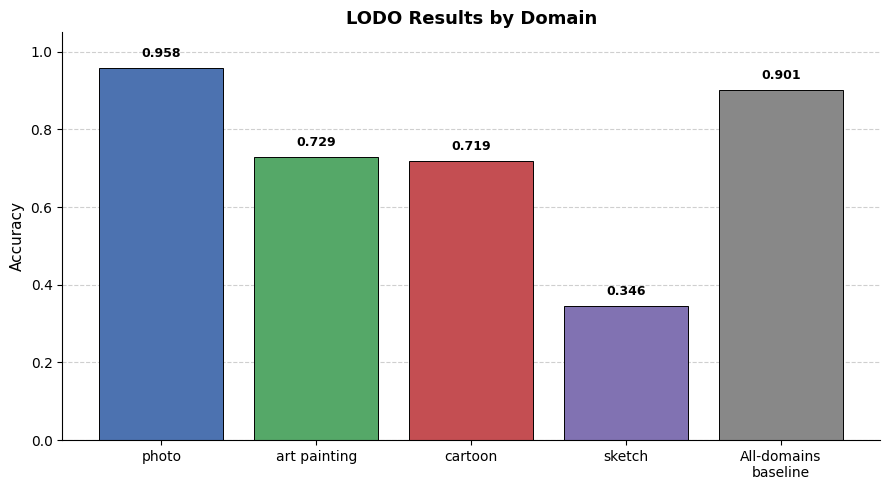

In [10]:
import matplotlib.pyplot as plt

# Data
results = {
    "photo": 0.9581,
    "art_painting": 0.7293,
    "cartoon": 0.7186,
    "sketch": 0.3461,
    "All-domains baseline": 0.9010
}

# Prepare labels & values; wrap long label onto two lines for neatness
labels = []
values = []
for k, v in results.items():
    if "All-domains" in k:
        labels.append("All-domains\nbaseline")   # wrap long label
    else:
        labels.append(k.replace("_", " "))       # nicer display for underscores
    values.append(v)

# Plot
fig, ax = plt.subplots(figsize=(9, 5))
x = range(len(labels))

# Draw bars; make baseline visually distinct
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#888888"]
bars = ax.bar(x, values, color=colors, edgecolor="black", linewidth=0.7)

# Axis and ticks
ax.set_ylim(0, 1.05)
ax.set_ylabel("Accuracy", fontsize=11)
ax.set_title("LODO Results by Domain", fontsize=13, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10, rotation=0, ha="center")

# Add horizontal grid lines for readability (below bars)
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.set_axisbelow(True)

# Annotate values above bars with consistent alignment
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="semibold"
    )

# Tidy up spines
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Save optionally:
# fig.savefig("lodo_results_bar.png", dpi=300)
plt.show()
